In [1]:
import h2o
h2o.init()
from h2o.estimators import H2OIsolationForestEstimator

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_242"; OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~18.04-b08); OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)
  Starting server from /home/h2o/bin/miniconda3/envs/h2o/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpj0kffj6g
  JVM stdout: /tmp/tmpj0kffj6g/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpj0kffj6g/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.5
H2O cluster version age:,"1 year, 1 month and 3 days !!!"
H2O cluster name:,H2O_from_python_unknownUser_m1zrel
H2O cluster total nodes:,1
H2O cluster free memory:,13.98 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


Anomaly detection case study

In [2]:
#Import dataset
credit_card = h2o.import_file('https://github.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/raw/master/creditcard.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
seed = 12345 # For reproducibility of the experiment
ntrees = 100 #Specify the number of Trees
isoforest = H2OIsolationForestEstimator( ntrees=ntrees, seed=seed)
# Specify x as a vector containing the names or indices of the predictor variables to use when building the model.
isoforest.train(x=credit_card.col_names[0:30], training_frame=credit_card)

isolationforest Model Build progress: |███████████████████████████████████| 100%


In [4]:
predictions = isoforest.predict(credit_card)

predictions

isolationforest prediction progress: |████████████████████████████████████| 100%


predict,mean_length
0.0407125,6.84
0.0203562,6.92
0.170483,6.33
0.0814249,6.68
0.0534351,6.79
0.0254453,6.9
0.0279898,6.89
0.19084,6.25
0.0458015,6.82
0.0279898,6.89


In [5]:
predictions.cor()

predict,mean_length
1,-1
-1,1


In [6]:
quantile = 0.95
quantile_frame = predictions.quantile([quantile])
quantile_frame

Probs,predictQuantiles,mean_lengthQuantiles
0.95,0.178117,6.98


In [7]:
threshold = quantile_frame[0, "predictQuantiles"]
predictions["predicted_class"] = predictions["predict"] > threshold
predictions["class"] = credit_card["Class"]
predictions

predict,mean_length,predicted_class,class
0.0407125,6.84,0,0
0.0203562,6.92,0,0
0.170483,6.33,0,0
0.0814249,6.68,0,0
0.0534351,6.79,0,0
0.0254453,6.9,0,0
0.0279898,6.89,0,0
0.19084,6.25,1,0
0.0458015,6.82,0,0
0.0279898,6.89,0,0


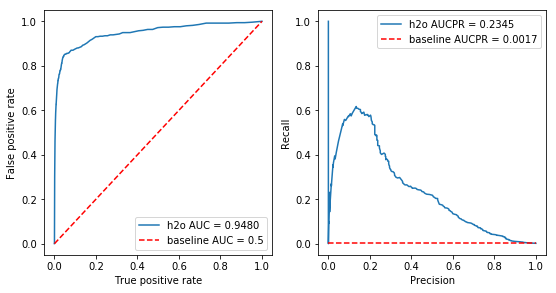

In [8]:
%matplotlib inline
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

 
def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score
 
 
def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score
 
 
def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)
 
 
def prediction_summary(labels, predicted_score, predicted_class, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
 
    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate",
                "True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate",
                "True positive rate", "baseline AUC = 0.5", "r--")
 
    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall",
                "Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = sum(labels)/len(labels)
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall",
                "Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")
 
    plt.show()
    return axes
 
 
def figure():
    fig_size = 4.5
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)
 
 
h2o_predictions = predictions.as_data_frame()
 
figure()
axes = prediction_summary(
    h2o_predictions["class"], h2o_predictions["predict"], h2o_predictions["predicted_class"], "h2o")